# Predicting Heart Attack Risk Using Sleep, Work, and Health Habits in Married Adults



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance


### Data Cleaning and Data Preprocessing

In [107]:

df = pd.read_csv("nhis_2022.csv")  

df = df[df["MARSTCUR"] == 1]

# Filter out invalid values
df = df[
    (df["HRSLEEP"].between(1, 24)) &
    (df["HOURSWRK"].between(1, 95)) &
    (df["AGE"].between(18, 85)) &
    (df["SEX"].isin([1, 2])) &
    (df["BMICALC"].between(12.0, 50.0)) &
    (df["MOD10DMIN"].between(1, 995)) &
    (df["VIG10DMIN"].between(1, 995)) &
    (df["HEARTATTEV"].isin([1, 2]))
]

df = df.rename(columns={
    "HRSLEEP": "Hours_Sleep",
    "HOURSWRK": "Work_Hours",
    "AGE": "Age",
    "SEX": "Sex",
    "MOD10DMIN": "Moderate_Activity_Min",
    "VIG10DMIN": "Vigorous_Activity_Min"
})

df["HEARTATTEV"] = df["HEARTATTEV"].map({1: 0, 2: 1})
df["Sex"] = df["Sex"].map({1: 0, 2: 1})  # 0 = Male, 1 = Female

def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25.0:
        return "Normal"
    elif 25.0 <= bmi < 30.0:
        return "Overweight"
    else:
        return "Obese"

df["BMI_CAT"] = df["BMICALC"].apply(categorize_bmi)
df = pd.get_dummies(df, columns=["BMI_CAT"], prefix="BMI", drop_first=True)

base_features = ["Hours_Sleep", "Work_Hours", "Age", "Sex", "Moderate_Activity_Min", "Vigorous_Activity_Min"]
bmi_dummies = [col for col in df.columns if col.startswith("BMI_")]
features = base_features + bmi_dummies

df = df[features + ["HEARTATTEV"]]
X = df[features]
y = df["HEARTATTEV"]

df = df.reset_index(drop=True)

print(" Final dataset shape:", df.shape)
print(" Feature matrix shape:", X.shape)
print(" Heart attack cases (label=1):", y.sum())

 Final dataset shape: (2848, 10)
 Feature matrix shape: (2848, 9)
 Heart attack cases (label=1): 25


### Visualizing Class Imbalance 

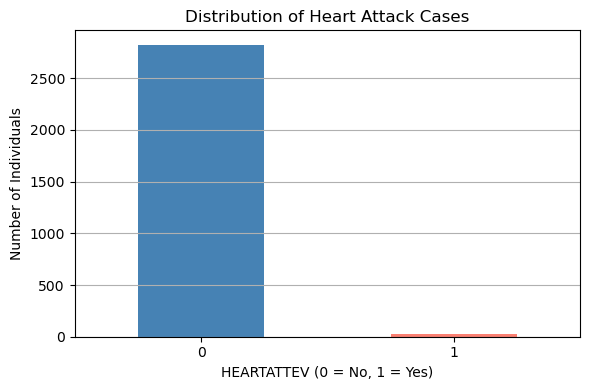

In [108]:
plt.figure(figsize=(6,4))
pd.Series(y).value_counts().sort_index().plot(kind='bar', color=["steelblue", "salmon"])
plt.title("Distribution of Heart Attack Cases")
plt.xlabel("HEARTATTEV (0 = No, 1 = Yes)")
plt.ylabel("Number of Individuals")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Visualizing Age distribution of Married Adults

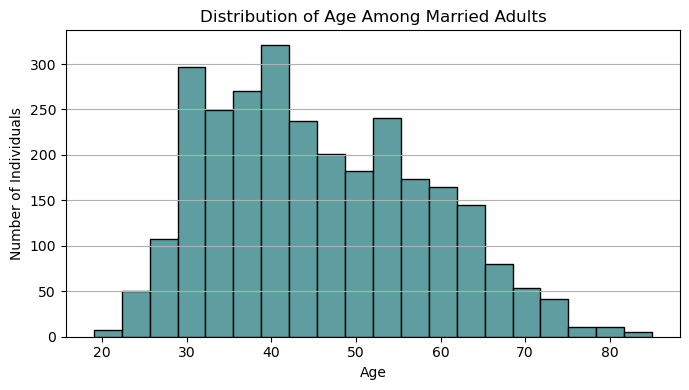

In [109]:
# Plot histogram of AGE
plt.figure(figsize=(7,4))
df["Age"].plot(kind='hist', bins=20, color="cadetblue", edgecolor='black')
plt.title("Distribution of Age Among Married Adults")
plt.xlabel("Age")
plt.ylabel("Number of Individuals")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Train Test Split 

Due to class imbalance, we applied the RandomOverSampler to balance the class distribution in the training data, which helps improve the model’s performance during prediction

In [110]:
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)  # Stratify because of class imbalance
    
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Resampled training class counts:")
print(pd.Series(y_train_resampled).value_counts())

print("Original y_train distribution:")
print(pd.Series(y_train).value_counts())

print("Original y_test distribution:")
print(pd.Series(y_test).value_counts())

Resampled training class counts:
HEARTATTEV
0    2258
1    2258
Name: count, dtype: int64
Original y_train distribution:
HEARTATTEV
0    2258
1      20
Name: count, dtype: int64
Original y_test distribution:
HEARTATTEV
0    565
1      5
Name: count, dtype: int64


#### Visualuzation of  Class Distribution Before and After Oversampling

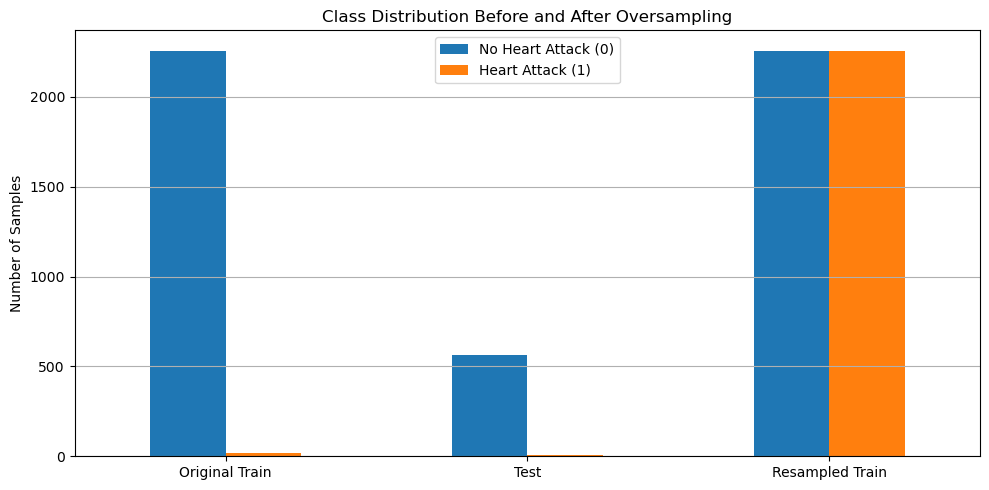

In [111]:
dist_df = pd.DataFrame({
    'Original Train': pd.Series(y_train).value_counts(),
    'Test': pd.Series(y_test).value_counts(),
    'Resampled Train': pd.Series(y_train_resampled).value_counts()
}).T

dist_df.columns = ['No Heart Attack (0)', 'Heart Attack (1)']

# Plot
dist_df.plot(kind='bar', figsize=(10, 5), rot=0)
plt.title("Class Distribution Before and After Oversampling")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Linear SVM 


 Classification Report (Linear SVM):
              precision    recall  f1-score   support

           0      0.997     0.680     0.808       565
           1      0.022     0.800     0.042         5

    accuracy                          0.681       570
   macro avg      0.510     0.740     0.425       570
weighted avg      0.989     0.681     0.802       570



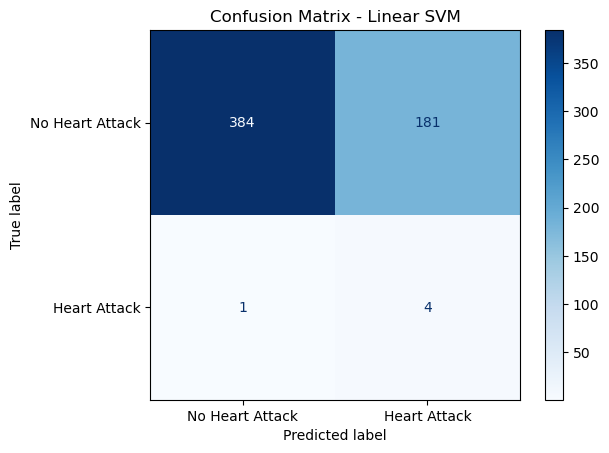

In [99]:
svm_linear = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', C=0.01, class_weight='balanced', random_state=42) 
)

svm_linear.fit(X_train_resampled, y_train_resampled)

y_pred = svm_linear.predict(X_test)

print("\n Classification Report (Linear SVM):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Attack", "Heart Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Linear SVM")
plt.show()


### Radial SVM 

 Classification Report (RBF SVM):
              precision    recall  f1-score   support

           0      0.995     0.752     0.857       565
           1      0.021     0.600     0.041         5

    accuracy                          0.751       570
   macro avg      0.508     0.676     0.449       570
weighted avg      0.987     0.751     0.850       570



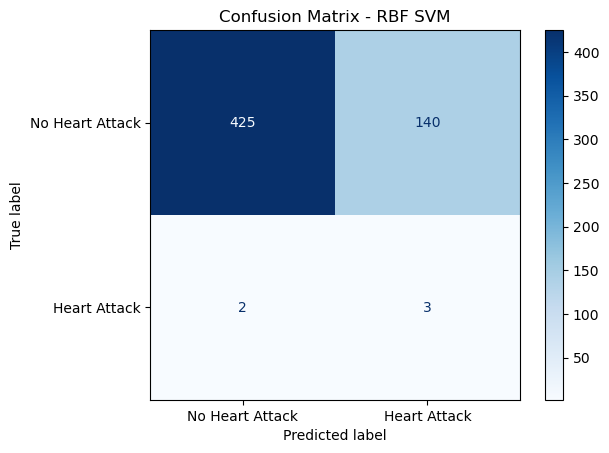

In [47]:
svm_rbf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma=0.01, random_state=42)  
)


svm_rbf.fit(X_train_resampled, y_train_resampled)

y_pred_rbf = svm_rbf.predict(X_test)

print(" Classification Report (RBF SVM):")
print(classification_report(y_test, y_pred_rbf, digits=3))

cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Attack", "Heart Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - RBF SVM")
plt.show()

### Polynomial SVM

 Classification Report (Polynomial SVM):
              precision    recall  f1-score   support

           0      0.994     0.850     0.916       565
           1      0.023     0.400     0.043         5

    accuracy                          0.846       570
   macro avg      0.508     0.625     0.480       570
weighted avg      0.985     0.846     0.908       570



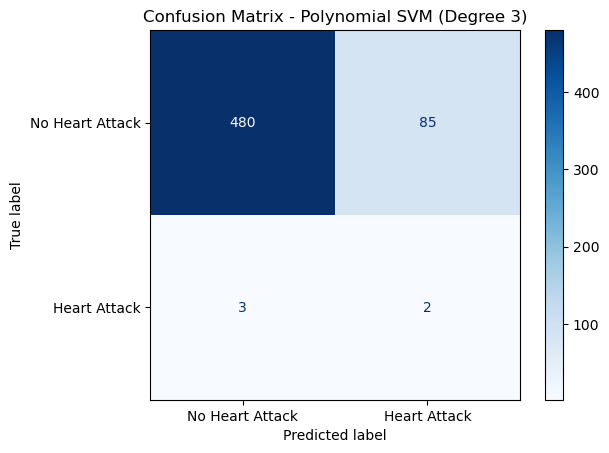

In [48]:
svm_poly = make_pipeline(
    StandardScaler(),
    SVC(kernel='poly', C=1.0, degree=3, random_state=42)  
)

svm_poly.fit(X_train_resampled, y_train_resampled)

y_pred_poly = svm_poly.predict(X_test)

print(" Classification Report (Polynomial SVM):")
print(classification_report(y_test, y_pred_poly, digits=3))

cm = confusion_matrix(y_test, y_pred_poly)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Attack", "Heart Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Polynomial SVM (Degree 3)")
plt.show()

### Hypertuning of Linear SVM 

In this code block we hypertune the Linear Support Vector Machine using the cost parameter. 

We also plotted the error rate against different cost values to observe how the error changes with varying cost parameters.

Best Linear SVM Params: {'svc__C': 0.1}
Best Accuracy (train, cross-validated): 0.7619571928380325


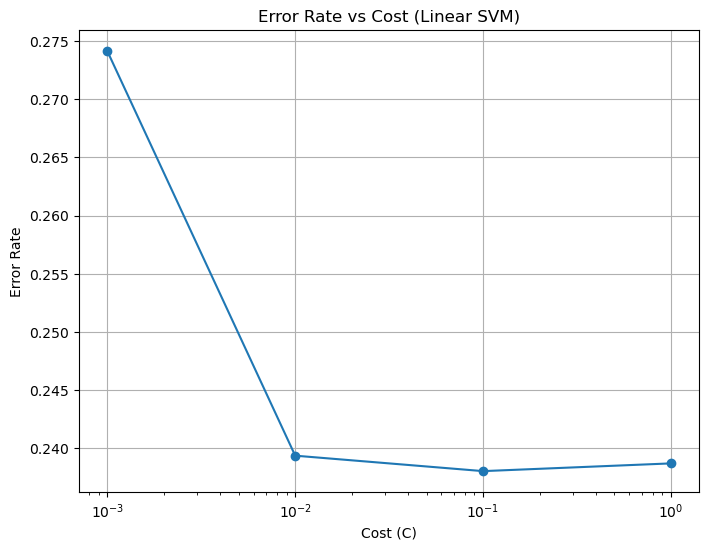

In [50]:
pipe_linear = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', random_state=42)
)

param_grid_linear = {
    'svc__C': [0.001, 0.01, 0.1, 1]
}

grid_linear = GridSearchCV(
    pipe_linear, 
    param_grid_linear, 
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1
)

grid_linear.fit(X_train_resampled, y_train_resampled)

print("Best Linear SVM Params:", grid_linear.best_params_)
print("Best Accuracy (train, cross-validated):", grid_linear.best_score_)


cv_results_linear = pd.DataFrame(grid_linear.cv_results_)

cv_results_linear["error_rate"] = 1 - cv_results_linear["mean_test_score"]

plt.figure(figsize=(8,6))
plt.plot(cv_results_linear['param_svc__C'], cv_results_linear['error_rate'], marker='o')

plt.xscale('log')  
plt.xlabel('Cost (C)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Cost (Linear SVM)')
plt.grid(True)
plt.show()

### Hypertuning of Radial SVM 

In this code block we hypertune the Radial Support Vector Machine using the cost parameter and Gamma Parameter. 

We also plotted the error rate against different cost values and gamma values to observe how the error changes with varying cost parameters and gamma parameters.

Best Poly SVM Params: {'svc__C': 10, 'svc__gamma': 0.1}
Best Accuracy (train, cross-validated): 0.9818412567743705


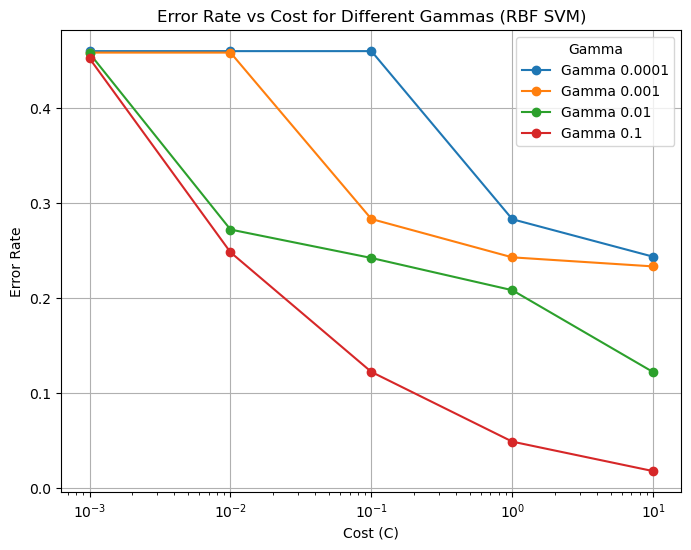

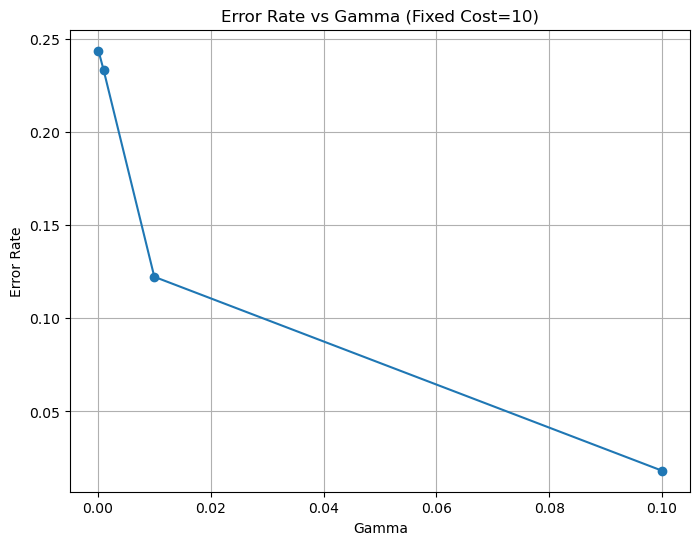

In [113]:
pipe_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
param_grid_rbf = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1]
}

grid_rbf = GridSearchCV(pipe_rbf, param_grid_rbf, scoring='accuracy', cv=5, n_jobs=-1)
grid_rbf.fit(X_train_resampled, y_train_resampled)

print("Best Poly SVM Params:", grid_rbf.best_params_)
print("Best Accuracy (train, cross-validated):", grid_rbf.best_score_)
# Results DataFrame
cv_results_rbf = pd.DataFrame(grid_rbf.cv_results_)
cv_results_rbf["error_rate"] = 1 - cv_results_rbf["mean_test_score"]

# Plot 1: Error Rate vs Cost for Different Gammas
plt.figure(figsize=(8, 6))
for gamma_val in sorted(cv_results_rbf['param_svc__gamma'].unique()):
    subset = cv_results_rbf[cv_results_rbf['param_svc__gamma'] == gamma_val]
    plt.plot(subset['param_svc__C'], subset['error_rate'], marker='o', label=f'Gamma {gamma_val}')
plt.xscale('log')
plt.xlabel('Cost (C)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Cost for Different Gammas (RBF SVM)')
plt.legend(title='Gamma')
plt.grid(True)
plt.show()

# Plot 2: Error Rate vs Gamma (Fixed Cost)
best_C = grid_rbf.best_params_['svc__C']
subset_C = cv_results_rbf[cv_results_rbf['param_svc__C'] == best_C]
plt.figure(figsize=(8, 6))
plt.plot(subset_C['param_svc__gamma'], subset_C['error_rate'], marker='o')
plt.xlabel('Gamma')
plt.ylabel('Error Rate')
plt.title(f'Error Rate vs Gamma (Fixed Cost={best_C})')
plt.grid(True)
plt.show()

### Hypertuning of Polynomial SVM 

In this code block we hypertune the Polynomial Support Vector Machine using the cost parameter and Degree Parameter. 

We also plotted the error rate against different cost values and degree values to observe how the error changes with varying cost parameters and degree parameters.

Best Poly SVM Params: {'svc__C': 100, 'svc__degree': 4}
Best Accuracy (train, cross-validated): 0.9838338772430151


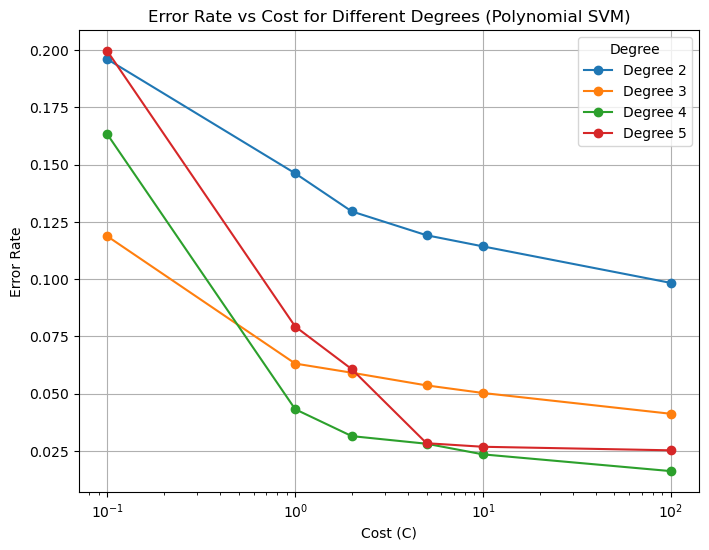

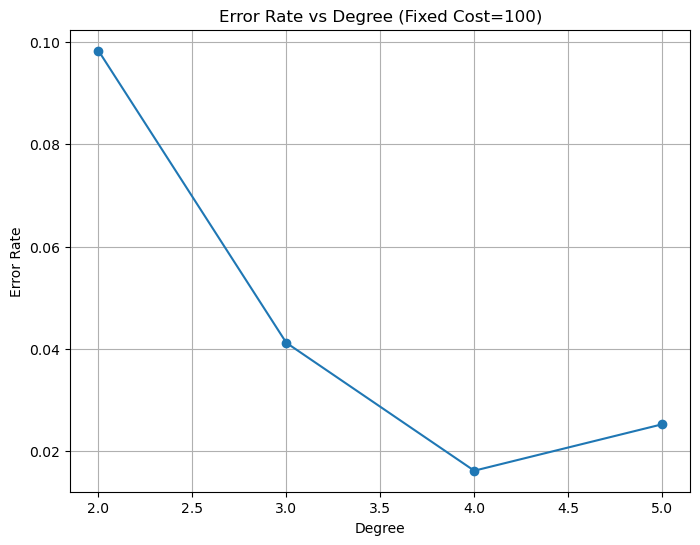

In [64]:
pipe_poly = make_pipeline(
    StandardScaler(),
    SVC(kernel='poly', random_state=42)
)

param_grid_poly = {
    'svc__C': [0.1, 1, 2, 5, 10, 100],
    'svc__degree': [2, 3, 4,5]
}

grid_poly = GridSearchCV(
    pipe_poly, 
    param_grid_poly, 
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1
)

grid_poly.fit(X_train_resampled, y_train_resampled)

print("Best Poly SVM Params:", grid_poly.best_params_)
print("Best Accuracy (train, cross-validated):", grid_poly.best_score_)


cv_results_poly = pd.DataFrame(grid_poly.cv_results_)

cv_results_poly["error_rate"] = 1 - cv_results_poly["mean_test_score"]

plt.figure(figsize=(8,6))
for deg in sorted(cv_results_poly['param_svc__degree'].unique()):
    subset = cv_results_poly[cv_results_poly['param_svc__degree'] == deg]
    plt.plot(subset['param_svc__C'], subset['error_rate'], marker='o', label=f'Degree {deg}')

plt.xscale('log')  
plt.xlabel('Cost (C)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Cost for Different Degrees (Polynomial SVM)')
plt.legend(title='Degree')
plt.grid(True)
plt.show()

best_C = grid_poly.best_params_['svc__C']

subset_C = cv_results_poly[cv_results_poly['param_svc__C'] == best_C]

plt.figure(figsize=(8,6))
plt.plot(subset_C['param_svc__degree'], subset_C['error_rate'], marker='o')
plt.xlabel('Degree')
plt.ylabel('Error Rate')
plt.title(f'Error Rate vs Degree (Fixed Cost={best_C})')
plt.grid(True)
plt.show()

### Model Evaluation After hypertuning. 

After hypertuning the models we display the classification report of each model along with the Confusion Matrix

 Best Linear SVM Results:
Accuracy: 0.6912280701754386
              precision    recall  f1-score   support

           0      0.997     0.690     0.816       565
           1      0.022     0.800     0.043         5

    accuracy                          0.691       570
   macro avg      0.510     0.745     0.430       570
weighted avg      0.989     0.691     0.809       570



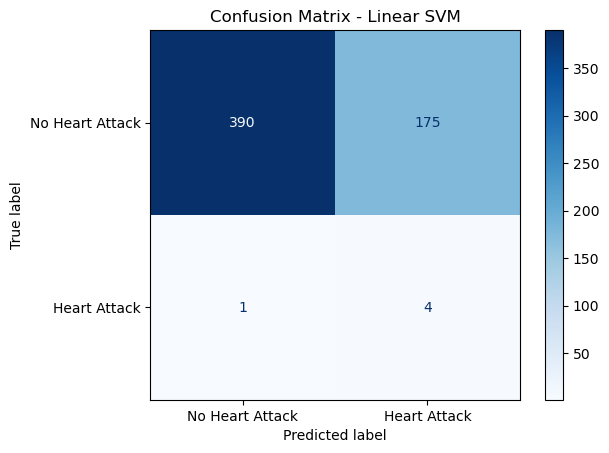


Best RBF SVM Results:
Accuracy: 0.9526315789473684
              precision    recall  f1-score   support

           0      0.991     0.961     0.976       565
           1      0.000     0.000     0.000         5

    accuracy                          0.953       570
   macro avg      0.495     0.481     0.488       570
weighted avg      0.982     0.953     0.967       570



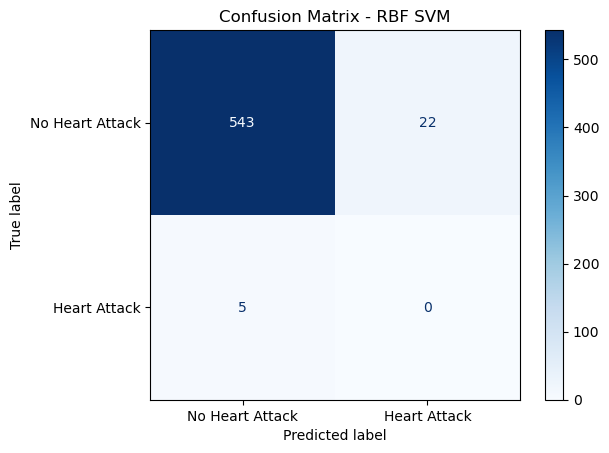


 Best Polynomial SVM Results:
Accuracy: 0.9596491228070175
              precision    recall  f1-score   support

           0      0.991     0.968     0.979       565
           1      0.000     0.000     0.000         5

    accuracy                          0.960       570
   macro avg      0.495     0.484     0.490       570
weighted avg      0.982     0.960     0.971       570



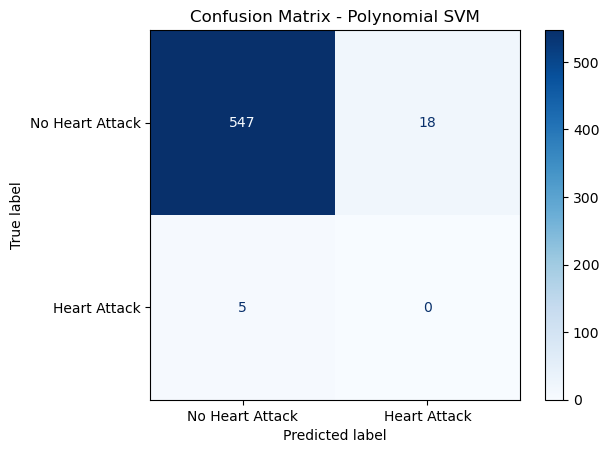

In [65]:
print(" Best Linear SVM Results:")
y_pred_linear = grid_linear.predict(X_test)
acc_linear = accuracy_score(y_test, y_pred_linear)
print("Accuracy:", acc_linear)
print(classification_report(y_test, y_pred_linear, digits=3))

cm_linear = confusion_matrix(y_test, y_pred_linear)
disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=["No Heart Attack", "Heart Attack"])
disp_linear.plot(cmap="Blues")
plt.title("Confusion Matrix - Linear SVM")
plt.grid(False)
plt.show()

print("\nBest RBF SVM Results:")
y_pred_rbf = grid_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print("Accuracy:", acc_rbf)
print(classification_report(y_test, y_pred_rbf, digits=3))

cm_rbf = confusion_matrix(y_test, y_pred_rbf)
disp_rbf = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=["No Heart Attack", "Heart Attack"])
disp_rbf.plot(cmap="Blues")
plt.title("Confusion Matrix - RBF SVM")
plt.grid(False)
plt.show()

print("\n Best Polynomial SVM Results:")
y_pred_poly = grid_poly.predict(X_test)
acc_poly = accuracy_score(y_test, y_pred_poly)
print("Accuracy:", acc_poly)
print(classification_report(y_test, y_pred_poly, digits=3))

cm_poly = confusion_matrix(y_test, y_pred_poly)
disp_poly = ConfusionMatrixDisplay(confusion_matrix=cm_poly, display_labels=["No Heart Attack", "Heart Attack"])
disp_poly.plot(cmap="Blues")
plt.title("Confusion Matrix - Polynomial SVM")
plt.grid(False)
plt.show()

### Comparing Accuracies of Models

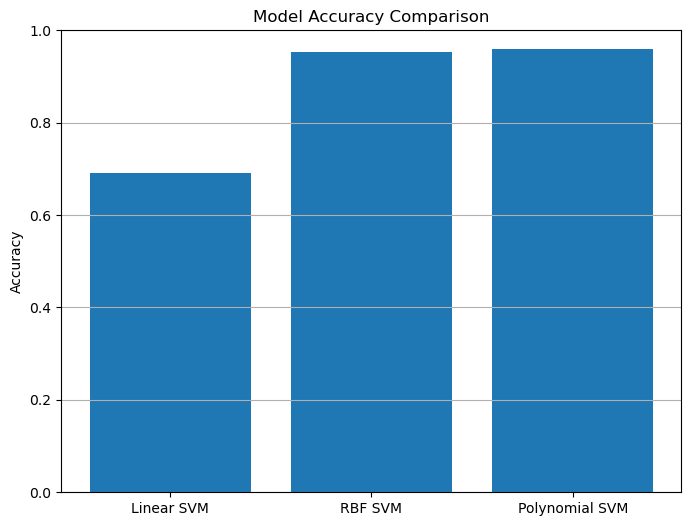

In [66]:
models = ['Linear SVM', 'RBF SVM', 'Polynomial SVM']

accuracies = [acc_linear, acc_rbf, acc_poly]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)

plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')
plt.show()

### Important Features of the linear SVM model 

In [67]:
best_linear_model = grid_linear.best_estimator_.named_steps['svc']

coef = best_linear_model.coef_[0]

feature_importance_linear = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': abs(coef)  
}).sort_values(by='Importance', ascending=False)

print("\n Top Important Features (Linear SVM):")
print(feature_importance_linear)


 Top Important Features (Linear SVM):
                 Feature  Importance
2                    Age    1.345479
3                    Sex    0.383481
0            Hours_Sleep    0.337179
1             Work_Hours    0.143138
7         BMI_Overweight    0.131442
8        BMI_Underweight    0.074048
5  Vigorous_Activity_Min    0.052579
4  Moderate_Activity_Min    0.031425
6              BMI_Obese    0.027197


### Important Features of the Radial SVM model 

In [68]:
pipe_rbf_best = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf', 
        C=grid_rbf.best_params_['svc__C'], 
        gamma=grid_rbf.best_params_['svc__gamma'],
        random_state=42
    )
)

pipe_rbf_best.fit(X_train_resampled, y_train_resampled)

result_rbf = permutation_importance(
    pipe_rbf_best, 
    X_test, 
    y_test, 
    n_repeats=30, 
    random_state=42, 
    n_jobs=-1
)

importance_rbf = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result_rbf.importances_mean
}).sort_values(by='Importance', ascending=False)

display(importance_rbf)

,Feature,Importance
1,Work_Hours,0.012281
7,BMI_Overweight,0.002924
0,Hours_Sleep,0.001930
6,BMI_Obese,0.000585
8,BMI_Underweight,-0.000117
3,Sex,-0.000760
2,Age,-0.002456
4,Moderate_Activity_Min,-0.003216
5,Vigorous_Activity_Min,-0.005263


### Important Features of the Polynomial SVM model 

In [69]:
pipe_poly_best = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='poly', 
        C=grid_poly.best_params_['svc__C'], 
        degree=grid_poly.best_params_['svc__degree'],
        random_state=42
    )
)

pipe_poly_best.fit(X_train_resampled, y_train_resampled)


result_poly = permutation_importance(
    pipe_poly_best, 
    X_test, 
    y_test, 
    n_repeats=30, 
    random_state=42, 
    n_jobs=-1
)

importance_poly = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result_poly.importances_mean
}).sort_values(by='Importance', ascending=False)

display(importance_poly)

,Feature,Importance
7,BMI_Overweight,0.042398
6,BMI_Obese,0.040994
1,Work_Hours,0.010585
3,Sex,0.002982
2,Age,0.002690
4,Moderate_Activity_Min,0.001170
8,BMI_Underweight,0.000234
0,Hours_Sleep,-0.001754
5,Vigorous_Activity_Min,-0.003450


### Plotting of the Support Vector Machine 

In this code block we plot the linear support vector machine for the Hours_Sleep and Age predictors 

/Users/sanro/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


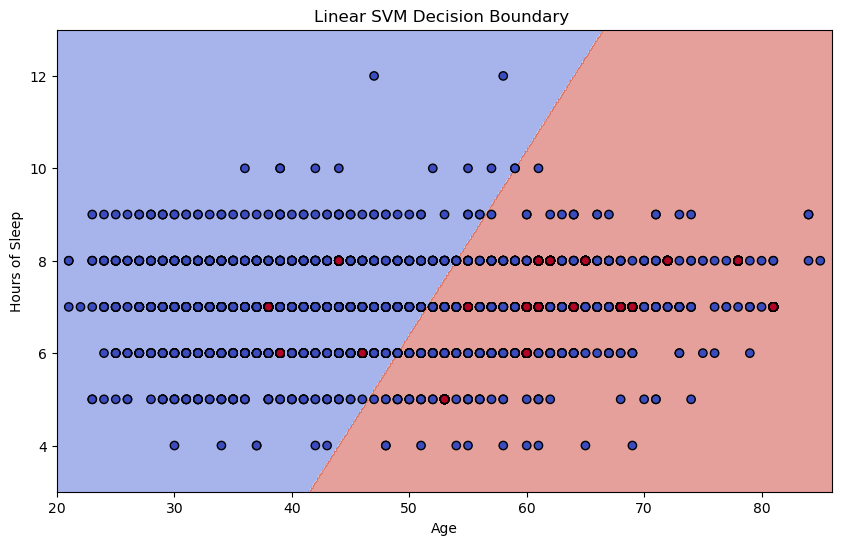

In [114]:
feature1 = "Age"
feature2 = "Hours_Sleep"

X_train_2d = X_train_resampled[[feature1, feature2]]
y_train_2d = y_train_resampled

svm_linear_2d = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', C=1.0, random_state=42)
)

svm_linear_2d.fit(X_train_2d, y_train_2d)

x_min, x_max = X_train_2d[feature1].min() - 1, X_train_2d[feature1].max() + 1
y_min, y_max = X_train_2d[feature2].min() - 1, X_train_2d[feature2].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

Z = svm_linear_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[feature1], X_train_2d[feature2], c=y_train_2d, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel("Age")
plt.ylabel("Hours of Sleep")
plt.title("Linear SVM Decision Boundary ")
plt.show()

### Plot of an example SVM decision boundary

plot of an example Radial SVM decision boundaryon two strong predictor variables Age and Hours_sleep 

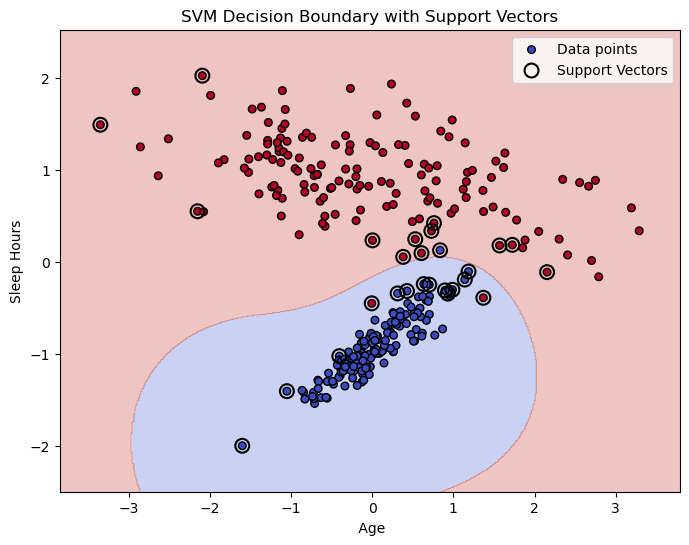

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=300, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=1.5, random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = SVC(kernel='rbf', C=1, gamma='scale')
model.fit(X_scaled, y)

xx, yy = np.meshgrid(
    np.linspace(X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5, 500),
    np.linspace(X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5, 500)
)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=30, cmap=plt.cm.coolwarm, edgecolors='k', label='Data points')

plt.scatter(
    model.support_vectors_[:, 0], 
    model.support_vectors_[:, 1], 
    s=100, facecolors='none', edgecolors='black', 
    linewidths=1.5, label='Support Vectors'
)

plt.title("SVM Decision Boundary with Support Vectors")
plt.xlabel(" Age")
plt.ylabel("Sleep Hours")
plt.legend()
plt.show()